## Machine Learning Online Class - Exercise 4 Neural Network Learning
Requires : scipy, scikit-learn, keras, tensorflow

### Introduction

In this exercise, you will implement the backpropagation algorithm for neural
networks and apply it to the task of hand-written digit recognition.

### Python imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.optimize import check_grad
from scipy.io import loadmat

from keras import initializers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from IPython.display import HTML

%matplotlib inline

Using TensorFlow backend.


### Setup the parameters (NN architecture)

Our neural network has 3 layers (an input layer, a hidden layer and an output layer).<br>
Recall that our inputs are pixel values of digit images. <br>
Since the images are of size 20x20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.<br>
You have been provided with a set of network parameters $ (\theta^{(1)},\theta^{(2)})$ already trained by us. <br>
These are stored in ex3weights.mat and will be loaded by ex3 nn.m into Theta1 and Theta2 <br>
The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [2]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10

### Part 1: Loading and Visualizing Data

#### Load training data

This is the same dataset as we used in preivous exercise.<br>
There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. <br>
Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. <br>
Each of these training examples becomes a single row in our data matrix X. <br>
This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.<br><br>

$$ X=
\quad
\begin{bmatrix} 
- & (x^{(1)})^T & - \\
- & (x^{(2)})^T & - \\
  &\vdots & \\
- & (x^{(m)})^T & - 
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. <br>
To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten.  <br>
Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

In [3]:
data = loadmat('ex4data1.mat')

In [4]:
X = data['X']
y = data['y']

In [5]:
m = len(X)

#### Randomly select 100 data points to display

In [6]:
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100],:]

In [7]:
def displayData(images):
    
    n = len(images)
    #ncols = 10
    dm = divmod(n,10)
    
    nrows = np.floor(np.sqrt(n))
    ncols = np.ceil(n / nrows)
    
    #nrows = dm[0] if dm[0]==0 else dm[0]+1
    
    fig = plt.figure(figsize=(8, 8))

    for i in range(n):
        sub = fig.add_subplot(nrows, ncols, i + 1)
        sub.axis('off')
        sub.imshow(images[i].reshape(20,20).T,cmap='gray')
    
    return fig

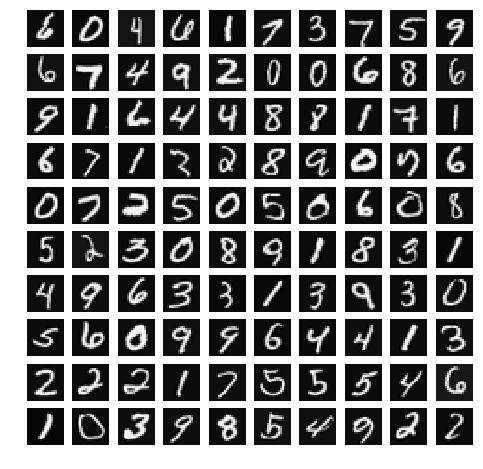

In [8]:
fig = displayData(sel)

### Part 2: Loading (pre-initialized) weights

In [9]:
weights = loadmat('ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

##### Unroll parameters (i.e. put Theta1 and Theta2 into one single vector)

In [10]:
nn_params = np.r_[Theta1.ravel(),Theta2.ravel()]

### Part 3 / 4 : Compute regularized cost function

The cost function for neural networks with regularization is given by :
$$J(\theta) = \frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)}\log (h_{\theta}(x^{(i)}_k) - (1-y_k^{(i)})\log (1-h_{\theta}(x^{(i)})_k ] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j,k}^{(2)})^2 ]$$

In [11]:
# Define usual sigmoid function (neurons are sigmoid units)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_reg):
    
    # First reshape unrolled nn_params to retrieve Theta1 and Theta2
    Theta1 = nn_params[:(hidden_layer_size *(input_layer_size + 1))].reshape(hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[(hidden_layer_size *(input_layer_size + 1)):].reshape(num_labels, hidden_layer_size + 1)
    
    m = X.shape[0]
    
    # Add bias
    X = np.c_[np.ones(m),X] 
    
    # Forward propagate data
    # Return (m x num_labels) matrix (final layer activation output for each sample)
    h = sigmoid(np.c_[np.ones(m),sigmoid(X.dot(Theta1.T))].dot(Theta2.T))
    
    # Recode y as m*num_labels matrix of 0 and 1
    # We use here numpy broadcasting
    code = np.arange(1,num_labels + 1)
    y_rec = (y == code).astype('int')
    
    # Compute overall cost without regularization term
    J0 = (1 / m) * np.sum(np.sum((-y_rec * np.log(h) - (1 - y_rec) * np.log(1 - h)), axis=1), axis = 0)
    
    # Compute regularization term
    reg_term = (lambda_reg / (2* m)) * (np.sum(np.sum(Theta1[:,1:]**2, axis = 1), axis = 0) +
                                        np.sum(np.sum(Theta2[:,1:]**2, axis = 1), axis = 0))
    
    J = J0 + reg_term
    
    return J   

In [13]:
lambda_reg = 0
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X,y, lambda_reg)

In [14]:
print("Cost at parameters (loaded from ex4weights): {:2.6f}".format(J))
print("Expected cost : 0.287629 \n")

Cost at parameters (loaded from ex4weights): 0.287629
Expected cost : 0.287629 



In [15]:
lambda_reg = 1
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X,y, lambda_reg)

In [16]:
print("Cost at parameters (loaded from ex4weights): {:2.6f}".format(J))
print("Expected cost : 0.383770 \n")

Cost at parameters (loaded from ex4weights): 0.383770
Expected cost : 0.383770 



### Part 5: Sigmoid Gradient

The gradient for the sigmoid function can be computed as :
$$ g'(z)= \frac{d}{dz}g(z)=g(z)(1-g(z))  $$
where :
$$g(z) = \frac{1}{1+e^{-z}}$$

In [17]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [18]:
g = sigmoidGradient(np.array([-1,-0.5,0,0.5,1]))

In [19]:
print("Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n")
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:

[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


### Part 6: Initializing Parameters

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking.<br>
One effective strategy for random initialization is to randomly select values for $\theta^{(l)}$ uniformly in the range $[-\epsilon_{init},\epsilon_{init}]$<br>
A good choice for $\epsilon_{init}$ is $\epsilon_{init}=\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$ where $L_{in}=s_t$ and $L_{out}=s_{t+1}$ are the number of units in the layers adjacent to $\theta^{(l)}$<br>
This range of values ensures that the parameters are kept small and makes the learning more efficient.<br>
Applying the formula in our case :  $\epsilon_{init}=0.12$

In [20]:
# Initialize W randomly so that we break the symmetry while training the neural network.
# Note: The first column of W corresponds to the parameters for the bias unit
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init 

In [21]:
# Randomly initialize weights
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

In [22]:
# Unroll parameters
initial_nn_params = np.r_[Theta1.ravel(),Theta2.ravel()]

### Part 7: Implement Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function.
Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function J() using an
advanced optimizer.

Recall that the intuition behind the backpropagation algorithm is as follows. <br>
Given a training example $(x^{(t)}, y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_{\theta}(x)$. <br>
Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was \responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). <br>
For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer
$(l + 1)$.

In detail, here is the backpropagation algorithm.<br> 
You should implement steps 1 to 4 in a loop that processes one example
at a time. <br> 
Concretely, you should implement a for-loop for $t = 1:m$ and
place steps 1-4 below inside the for-loop, with the $t$-th iteration performing
the calculation on the $t$-th training example $(x^{(t)}, y^{(t)})$. <br>
Step 5 will divide the
accumulated gradients by m to obtain the gradients for the neural network cost function.

1. Set the input layer's values $(a^{(1)})$ to the $t$-th training sample $x^{(t)}$<br>
Perform a feedforward pass computing the activations $(z^{(2)},a^{(2)},z^{(3)},a^{(3)})$ for layers 2 and 3. <br>
Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$  and $a^{(2)}$ also include the bias unit.<br><br>

2. For each unit $k$ in layer 3 (the ouput layer), set 
$$\delta_k^{(3)}=(a_k^{(3)}-y_k)$$ <br>
where $y_k \in \{0,1\}$ indicates whether the current training example belongs to class k ($y_k = 1$), or if it belongs to a different class ($y_k = 0$).<br><br>

3. For the hidden layer $l$ = 2, set :
$$\delta^{(2)}=(\Theta^{(2)})^T \delta^{(3)}.*g'(z^{(2)})$$<br><br>

4. Accumulate the gradient from this example using the following formula : <br>
$$\Delta^{(L)} = \Delta^{(L)} + \delta^{(l+1)}(a^{(l)})^T$$<br><br>

5. Obtain the gradient for the neural network cost function by dividing the accumulated gradients by m<br>
$$ \frac{\partial J(\theta)}{\partial \theta_{ij}^{(l)}} = D_{ij}^{(L)} = \frac{1}{m}\Delta_{ij}^{(L)} \hspace{10 mm} \text{for} \hspace{3 mm}j=0$$
$$ \frac{\partial J(\theta)}{\partial \theta_{ij}^{(l)}} = D_{ij}^{(L)} = \frac{1}{m}\Delta_{ij}^{(L)} + \frac{\lambda}{m}\theta_{ij}^{(l)}\hspace{10 mm} \text{for} \hspace{3 mm}j\geqslant1$$


#### Cost gradient function

In [23]:
def nnGradFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_reg):
    
    # First reshape unrolled nn_params to retrieve Theta1 and Theta2
    Theta1 = nn_params[:(hidden_layer_size *(input_layer_size + 1))].reshape(hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[(hidden_layer_size *(input_layer_size + 1)):].reshape(num_labels, hidden_layer_size + 1)
    
    m = X.shape[0]
    
    
    # Forward propagation - store intermediate activation values
    a1 = np.c_[np.ones(m),X]
    z2 = a1.dot(Theta1.T)
    a2 = np.c_[np.ones(m),sigmoid(z2)]
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    
    # Recode y as m*num_labels matrix of 0 and 1
    # We use here numpy broadcasting
    code = np.arange(1,num_labels + 1)
    y_rec = (y == code).astype('int')
    
    # Local gradients
    delta3 = a3 - y_rec
    delta2 = delta3.dot(Theta2) * sigmoidGradient(np.c_[np.ones(m), z2])
    
    # Global gradients
    Delta2 = delta3.T.dot(a2)
    Delta1 = delta2[:,1:].T.dot(a1)
    
    # Gradients with regularization
    Theta1_grad = (1/m) * Delta1 + (lambda_reg / m) * np.c_[np.zeros((Theta1.shape[0],1)), Theta1[:, 1:]]
    Theta2_grad = (1/m) * Delta2 + (lambda_reg / m) * np.c_[np.zeros((Theta2.shape[0],1)), Theta2[:, 1:]]
   
    # Unroll gradients
    grad = np.r_[Theta1_grad.ravel(),Theta2_grad.ravel()]
    
    return grad

#### Numerical gradient function (central finite difference)

In [24]:
def computeNumericalGradient(func, x):
    eps = 1e-4
      
    perturb = np.zeros(x.size)
    findiff = np.zeros(x.size)
    
    for p in range(x.size):
        perturb[p] = eps
        findiff[p] = (func(x + perturb) - func(x - perturb)) / (2 * eps)       
        perturb = np.zeros(x.size)       
        
    return findiff

In [25]:
#Testing numerical gradient
def f(x):
    return np.sum(x**2)

print("Exact derivative : {}".format(2*np.array([2,5,6])))
print("Finite diff appprox : {}".format(computeNumericalGradient(f,np.array([2,5,6]))))


Exact derivative : [ 4 10 12]
Finite diff appprox : [  4.  10.  12.]


#### Gradient checking

In [26]:
def checkNNGradients(lambda_reg = 0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initialize weights (same procedure as in m code using sin)
    def debugInitializeWeights(fan_out, fan_in):
        return (np.sin(np.arange(1,fan_out*(fan_in + 1)+1))/10).reshape(fan_out, fan_in + 1, order = 'F')
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y = (1 + np.mod(np.arange(1,m+1),num_labels)).reshape(m,1)
    
    # Unroll thetas
    nn_params = np.r_[Theta1.ravel(),Theta2.ravel()]
    
    grad = nnGradFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_reg)
    
    numgrad = computeNumericalGradient(lambda theta: nnCostFunction(theta,input_layer_size,
                                       hidden_layer_size,num_labels, X, y, lambda_reg),
                                       nn_params)
    result = np.c_[numgrad, grad]
    
    print("The following columns should be very similar \n")
    print("Left-Your Numerical Gradient, Right-Analytical Gradient\n")
    print(result)
    
    # Evaluate the norm of the difference
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    
    print("If your backpropagation implementation is correct, then")
    print("the relative difference will be small (less than 1e-9)\n")
    print("Relative difference : {}".format(diff))   

In [27]:
#lambda = 0
checkNNGradients()

The following columns should be very similar 

Left-Your Numerical Gradient, Right-Analytical Gradient

[[ -9.27825235e-03  -9.27825236e-03]
 [ -3.04978931e-06  -3.04978914e-06]
 [ -1.75060082e-04  -1.75060082e-04]
 [ -9.62660618e-05  -9.62660620e-05]
 [  8.89911959e-03   8.89911960e-03]
 [  1.42869450e-05   1.42869443e-05]
 [  2.33146358e-04   2.33146357e-04]
 [  1.17982666e-04   1.17982666e-04]
 [ -8.36010761e-03  -8.36010762e-03]
 [ -2.59383093e-05  -2.59383100e-05]
 [ -2.87468729e-04  -2.87468729e-04]
 [ -1.37149709e-04  -1.37149706e-04]
 [  7.62813551e-03   7.62813551e-03]
 [  3.69883213e-05   3.69883234e-05]
 [  3.35320349e-04   3.35320347e-04]
 [  1.53247079e-04   1.53247082e-04]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -4.68759764e-05  -4.68759769e-05]
 [ -3.76215585e-04  -3.76215587e-04]
 [ -1.66560294e-04  -1.66560294e-04]
 [  3.14544970e-01   3.14544970e-01]
 [  1.64090819e-01   1.64090819e-01]
 [  1.64567932e-01   1.64567932e-01]
 [  1.58339334e-01   1.58339334e-01]
 [  1.51

In [28]:
#lambda = 3
lambda_reg = 3
checkNNGradients(lambda_reg)

The following columns should be very similar 

Left-Your Numerical Gradient, Right-Analytical Gradient

[[ -9.27825235e-03  -9.27825236e-03]
 [ -1.67679797e-02  -1.67679797e-02]
 [ -6.01744725e-02  -6.01744725e-02]
 [ -1.73704651e-02  -1.73704651e-02]
 [  8.89911959e-03   8.89911960e-03]
 [  3.94334829e-02   3.94334829e-02]
 [ -3.19612287e-02  -3.19612287e-02]
 [ -5.75658668e-02  -5.75658668e-02]
 [ -8.36010761e-03  -8.36010762e-03]
 [  5.93355565e-02   5.93355565e-02]
 [  2.49225535e-02   2.49225535e-02]
 [ -4.51963845e-02  -4.51963845e-02]
 [  7.62813551e-03   7.62813551e-03]
 [  2.47640974e-02   2.47640974e-02]
 [  5.97717617e-02   5.97717617e-02]
 [  9.14587966e-03   9.14587966e-03]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -3.26881426e-02  -3.26881426e-02]
 [  3.86410548e-02   3.86410548e-02]
 [  5.46101547e-02   5.46101547e-02]
 [  3.14544970e-01   3.14544970e-01]
 [  1.18682669e-01   1.18682669e-01]
 [  2.03987128e-01   2.03987128e-01]
 [  1.25698067e-01   1.25698067e-01]
 [  1.76

#### Gradient checking using SciPy's check_grad
Check the correctness of a gradient function by comparing it against a (forward) finite-difference approximation of the gradient
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html

In [29]:
def checkNNGradientsSciPy(lambda_reg = 0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initialize weights (same procedure as in m code using sin)
    def debugInitializeWeights(fan_out, fan_in):
        return (np.sin(np.arange(1,fan_out*(fan_in + 1)+1))/10).reshape(fan_out, fan_in + 1, order = 'F')
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y = (1 + np.mod(np.arange(1,m+1),num_labels)).reshape(m,1)
    
    # Unroll thetas
    nn_params = np.r_[Theta1.ravel(),Theta2.ravel()]
    
    diff = check_grad(lambda theta: nnCostFunction(theta,input_layer_size,
                                       hidden_layer_size,num_labels, X, y, lambda_reg),
           lambda theta: nnGradFunction(theta,input_layer_size,
                                       hidden_layer_size,num_labels, X, y, lambda_reg),
           nn_params
           )
    
    print("Relative difference : {}".format(diff))
    
    return diff

In [30]:
diff = checkNNGradientsSciPy(3)

Relative difference : 1.7988051699156862e-07


### Part 8: Training NN

In [31]:
#You should also try different values of lambda
lambda_reg = 1

In [32]:
find_optimal_theta = minimize(fun=nnCostFunction, x0=initial_nn_params,
method = 'CG', jac=nnGradFunction, args = (input_layer_size, hidden_layer_size,num_labels, X,y,lambda_reg), options={'maxiter':50, 'disp':True})

         Current function value: 0.318865
         Iterations: 50
         Function evaluations: 121
         Gradient evaluations: 121


In [33]:
optimal_theta = find_optimal_theta.x

In [34]:
# Reshape unrolled nn_params to retrieve Theta1 and Theta2
optimal_theta1 = optimal_theta[:(hidden_layer_size *(input_layer_size + 1))].reshape(hidden_layer_size, input_layer_size + 1)
optimal_theta2 = optimal_theta[(hidden_layer_size *(input_layer_size + 1)):].reshape(num_labels, hidden_layer_size + 1)

### Part 9: Visualize Weights
You can now "visualize" what the neural network is learning by displaying the hidden units to see what features they are capturing in the data.

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. 
Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value ($a_{i}^l$ ) close to 1). 
For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. 
If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the \representation" captured by the hidden unit is to reshape this 400 dimensional vector into a 20 x 20 image and display it.

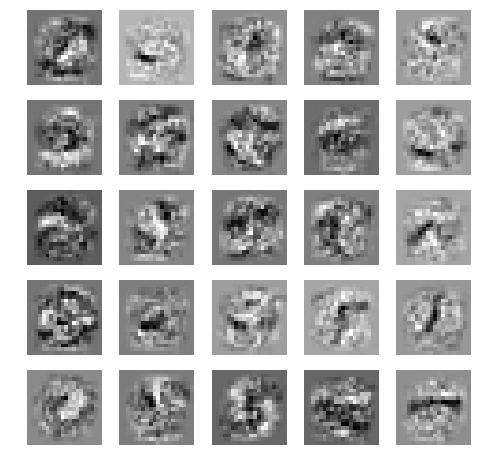

In [35]:
fig = displayData(optimal_theta1[:,1:])

### Part 10: Implement Predict

In [36]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    X = np.c_[np.ones(m),X]
    
    # Forward propagate data
    # Return (m x num_labels) matrix containing for each sample, the probability that it belongs to a given class
    prob_matrix = sigmoid(np.c_[np.ones(m),sigmoid(X.dot(Theta1.T))].dot(Theta2.T))
    
    # Return m-vector, containing for each sample the class having the max probability
    return np.argmax(prob_matrix,1) + 1 # array is indexed from 0 to nbclasses -1

In [37]:
pred = predict(optimal_theta1, optimal_theta2, X)

In [38]:
print("Training set accuracy = {:2.2f} %".format(np.mean((pred.reshape(-1,1) == y).astype('int'))*100))

Training set accuracy = 99.12 %


### Implement Neural network learning using Keras 

#### Set random number generator seed (ensures that results can be reproduced)

In [39]:
seed = 5
np.random.seed(seed)

   #### Setup NN parameters

In [40]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 50   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10

#### Load training data

In [41]:
data = loadmat('ex4data1.mat')

In [42]:
X = data['X']
y = data['y']
y[y == 10] = 0

In [43]:
m = X.shape[0]

#### Encode output variable (1:10 to array of 0s and 1s)

In [44]:
y_rec = np_utils.to_categorical(y, num_labels)

#### Define model (NN architecture and activation functions)

In [45]:
# Define a sequential model (sequence of layers)
model = Sequential()
# Add first layer with input and output size (Dense = fully-connected)
model.add(Dense(hidden_layer_size, input_dim=input_layer_size ,
                activation='sigmoid',
                kernel_regularizer=regularizers.l2(0),
                kernel_initializer=initializers.RandomUniform(minval=-0.13, maxval=0.13),
                bias_initializer=initializers.RandomUniform(minval=-0.13, maxval=0.13)
               ))
# Add second layer output size (no need to specify input size since fully-connected to previous one)
# We use softmax activation which is a generalization of sigmoid for multiple classes
# model.add(Dense(num_labels, activation='sigmoid',kernel_initializer=initializers.RandomUniform(minval=-0.13, maxval=0.13)))

model.add(Dense(num_labels,
                activation='softmax',
                kernel_regularizer=regularizers.l2(0),
                kernel_initializer=initializers.RandomUniform(minval=-0.13, maxval=0.13),
                bias_initializer=initializers.RandomUniform(minval=-0.13, maxval=0.13)
               ))


#### Compile model (to use with tensorflow)
We define here the cost/loss function as well as the optimization method (adam is the default)

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Learning

In [50]:
model.fit(X, y_rec, epochs=100, batch_size=m, verbose = 1 )

Epoch 1/100
5000/5000 [==============================] - 0s - loss: 1.3221 - acc: 0.7912
Epoch 2/100
5000/5000 [==============================] - 0s - loss: 1.3124 - acc: 0.7930
Epoch 3/100
5000/5000 [==============================] - 0s - loss: 1.3027 - acc: 0.7932
Epoch 4/100
5000/5000 [==============================] - 0s - loss: 1.2931 - acc: 0.7942
Epoch 5/100
5000/5000 [==============================] - 0s - loss: 1.2836 - acc: 0.7962
Epoch 6/100
5000/5000 [==============================] - 0s - loss: 1.2741 - acc: 0.7976
Epoch 7/100
5000/5000 [==============================] - 0s - loss: 1.2647 - acc: 0.7992
Epoch 8/100
5000/5000 [==============================] - 0s - loss: 1.2554 - acc: 0.8012
Epoch 9/100
5000/5000 [==============================] - 0s - loss: 1.2462 - acc: 0.8024
Epoch 10/100
5000/5000 [==============================] - 0s - loss: 1.2370 - acc: 0.8034
Epoch 11/100
5000/5000 [==============================] - 0s - loss: 1.2279 - acc: 0.8046
Epoch 12/100
5000/5

In [51]:
score = model.evaluate(X,y_rec,verbose = 0)

In [52]:
print("Training set accuracy = {:2.2f} %".format(score[1]*100))

Training set accuracy = 87.16 %
